In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def ode_rho_m(y: tuple, r, l, pi):
    rho, m = y
    drho_dt = (1-rho)*(2*pi + l/2*(rho**2+m**2)) - r*rho
    dm_dt = l*(1-rho)*rho*m - r*m
    return drho_dt, dm_dt

def poly3_rho_param_m(rho, r,l,pi,m):
    a, b = 1, -1
    c = 2*r/l + m**2
    d = -4*pi - m**2
    return a*rho**3 + b*rho**2 + c*rho + d

def poly3_rho_param_m_sols(r, l, pi, m):
    a, b = 1, -1
    c = 2*r/l + m**2
    d = -4*pi - m**2
    # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,np.sqrt(-1*radicand0))
        else:
            root0 = complex(np.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, np.sqrt(3))/2
    roots, roots_Re = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        roots.append(f0_root), roots_Re.append(f0_root.real)
    return roots_Re, roots

In [30]:
r, l = 0.1, 1
pi = 0.0
m = 0.5
solsRe, solsC = poly3_rho_param_m_sols(r, l, pi, 0.25)

for sol in solsC:
    if abs(sol.imag) < 1e-8:
        rho = sol.real
        print(f'm = {m}, rho = {rho}')
        valODEs = ode_rho_m((rho, m), r, l, pi)
        print(f'dot_m = {valODEs[1]}, dot_rho = {valODEs[0]}')

m = 0.5, rho = 0.7633858350930371
dot_m = 0.040313950936171725, dot_rho = 0.022182577960027663


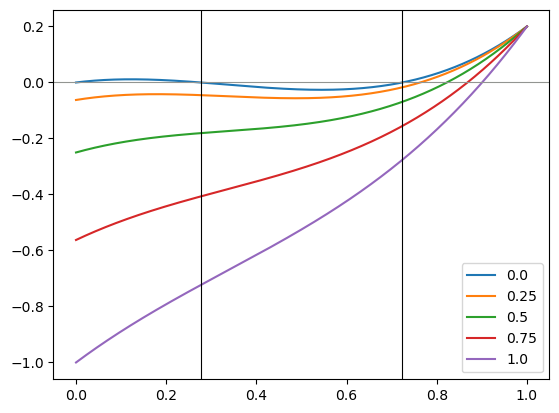

In [32]:
rhos = np.arange(0.0, 1.001, 0.001)
r, l = 0.1, 1
pi = 0.0

fig, ax = plt.subplots()
for m in [0.0, 0.25, 0.5, 0.75, 1.0]:
    polyVals = poly3_rho_param_m(rhos, r,l,pi, m)
    ax.plot(rhos, polyVals, label=m)
ax.legend()
ax.axhline(0.0, lw=0.8, color='xkcd:gray')

# sol when pi=0 and and m=0
rho = (1+np.sqrt(1-8*r/l))/2
ax.axvline(rho, lw=0.8, color='xkcd:black')
rho = (1-np.sqrt(1-8*r/l))/2
ax.axvline(rho, lw=0.8, color='xkcd:black')

In [24]:
1/9

0.1111111111111111

In [25]:
pi = 0
r, l = 0.1, 1
rho, m = (1+np.sqrt(1-8*r/l))/2, 0
valODEs = ode_rho_m((rho, m), r, l, pi)
print(f'dot_m = {valODEs[1]}, dot_rho = {valODEs[0]}')

dot_m = 0.0, dot_rho = 0.0


In [27]:
rho

0.7236067977499789